In [4]:
from PIL import Image
from wand.image import Image as wandImage
import cv2
import PyPDF2
import pytesseract
import argparse
import os
import io
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sys
import tempfile
import pickle
%matplotlib inline
plt.rcParams["figure.figsize"] = (50,30)

In [111]:
def pdf_page_to_png(src_pdf, pagenum = 0, resolution = 72, preprocess = "thresh"):
    '''
    Process one page of a pdf file, returning name of tempfile where grayscaled png is saved
    '''
    dst_pdf = PyPDF2.PdfFileWriter()
    dst_pdf.addPage(src_pdf.getPage(pagenum))

    pdf_bytes = io.BytesIO()
    dst_pdf.write(pdf_bytes)
    pdf_bytes.seek(0)

    img = wandImage(file = pdf_bytes, resolution = resolution)
    img.convert("png")

    tmp1 = tempfile.mkstemp(suffix='.png', prefix='tmp', dir=None, text=False)
    pngfilename = tmp1[1]
    tmp2 = tempfile.mkstemp(suffix='.png', prefix='tmp', dir=None, text=False)
    grayfilename = tmp2[1]

    img.save(filename = pngfilename)

    image = cv2.imread(pngfilename)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    if args["preprocess"] == "thresh":
        gray = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1]
 
    elif args["preprocess"] == "blur":
        gray = cv2.medianBlur(gray, 3)
 
    cv2.imwrite(grayfilename, gray)
    os.remove(pngfilename)
    
    return grayfilename

def ocr(filename, verbose=True, debug=True):
    # load the image as a PIL/Pillow image, apply OCR
    pagecontents = {}
    with Image.open(filename) as image:
        data = pytesseract.image_to_data(image, output_type="df.frame")
        boxes = pytesseract.image_to_boxes(image)
    try:
        df = pd.read_csv(io.StringIO(data), sep="\t")
        df = df.loc[(list(map(lambda x: str(x).strip()!='', df['text'])) & (df['conf']> -1) & (df['text']).notnull())]
        df = df.set_index(["block_num","par_num"])
        blockstats = {'block':[], 'n_par':[], 'n_line':[], 'top_at':[], 'bottom_at':[], 'left_at':[], 'right_at':[]}
        paragraphs = {}
        for block in df.index.levels[0]:
            blockstats['block'].append(block)
            blockstats['n_par'].append(len(np.unique(df.loc[block,].index.values)))
            blockstats['n_line'].append(df.loc[(block,)]['top'].count())
            blockstats['top_at'].append(min(df.loc[(block,)]['top']))
            blockstats['bottom_at'].append(max(df.loc[(block,)]['top']+df.loc[(block,)]['height']))
            blockstats['left_at'].append(min(df.loc[(block,)]['left']))
            blockstats['right_at'].append(max(df.loc[(block,)]['left']+df.loc[(block,)]['width']))
            paragraphs[block] = []
            for i in df.loc[block].index.unique():
                paragraphs[block].append(' '.join(list(map(lambda x: x.strip(), df.loc[block].loc[i,'text']))))
        blockstats = pd.DataFrame(data=blockstats).set_index('block')
        pagecontents['blockstats'] = blockstats
        pagecontents['paragraphs'] = paragraphs
    except:
        print("exception")

    # delete the temporary file
    if debug == True:
        print(filename)
        pagecontents['filename'] = filename
    else:
        os.remove(filename)
       
        
    if verbose == True:
        df = pd.read_csv(io.StringIO(data), sep="\t")
        df = df.loc[(list(map(lambda x: str(x).strip()!='', df['text'])) & (df['conf']> -1) & (df['text']).notnull())]
        pagecontents['data'] = df
        pagecontents['boxes'] = pd.read_csv(io.StringIO(boxes),
                                            sep="\s", header=None, names=["character", "x1","y1","x2","y2","c"])

    return pagecontents

# ocr process one page of filr
# example: pc = process_image_page(all_pages.sequence[360])
def process_image_page(page):
        
    with wandImage(page) as img:
        # save this page as png, using ImageMagick
        img.format = 'png'
#        image_filename = 'temp.png'
#        img.save(filename=image_filename)

        # load this page using openCV
        image = cv2.imread(image_filename)
#        image = cv2.imdecode(img)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

        # process image
        if args["preprocess"] == "thresh":
            gray = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1]
        elif args["preprocess"] == "blur":
            gray = cv2.medianBlur(gray, 3)

        # save processed image
        cv2.imwrite('gray.png', gray)

        # ocr processed image
        pagecontents = ocr('gray.png')

    return pagecontents


# ocr process entire file
def process_pdf(filename, resolution=300):
    # read all pages into memory
    all_pages = wandImage(filename=filename, resolution=resolution)
    pagecontents = {}
    for i, page in enumerate(all_pages.sequence):
        pagecontents[i] = process_image_page(page)

    pickle.dump( pagecontents, open( "contents.p", "wb" ) )
    return pagecontents

In [112]:
pc=process_image_page(all_pages.sequence[360])
pc

TypeError: Required argument 'flags' (pos 2) not found

In [113]:
pc

{'blockstats':        n_par  n_line  top_at  bottom_at  left_at  right_at
 block                                                     
 2          1       7      77        121      282      1453
 4         26     223     166       1268       73       755
 6         13     247    1297       2394       76       756
 7          1       5    1266       1295       76       762
 9          1     418     163       2117      779      1462
 10         1       8    2112       2150      780      1458
 11         7      45    2145       2400      784      1458
 13         1      13    2430       2461      161      1374,
 'paragraphs': {2: ['SAN FRANCISCO [ N ] DiIRxEcTORY. 275'],
  4: ['Nicholson J. H. book-keeper with Donohoe, Ralston & Co. dwl i45 Silver',
   'Nicholson John, dry goods, dw] 1503 Stockton',
   'Nicholson John, waiter Oceidental Hotel',
   'Nicholson John H. dwl 145 Silver',
   'Nicholson John J. book-keeper with P. J. White & Co. dwl 79 Stevenson House',
   'Nicholson Jobn Y. ship

In [16]:
args = {}

args["pdf_file"] = "1863Langley/1863Langley.pdf"
args["preprocess"] = "thresh"

src_pdf = PyPDF2.PdfFileReader(args["pdf_file"])
num_pages = src_pdf.getNumPages()

page_range = range(num_pages)
#page_range = range(78,90)
#page_range = range(0,9)

pagecontents = {}
for pagenum in page_range:
    imgfile = pdf_page_to_png(src_pdf, pagenum=pagenum, resolution=300, preprocess=args["preprocess"])
    print(pagenum)
    pagecontents[pagenum] = ocr(imgfile, debug=True)
    #os.remove(imgfile)

0
/var/folders/mr/0pxnxrgn29s88cb9g49gvqz40000gn/T/tmpzolzq8ez.png
1
/var/folders/mr/0pxnxrgn29s88cb9g49gvqz40000gn/T/tmp9rno8qb8.png
2
/var/folders/mr/0pxnxrgn29s88cb9g49gvqz40000gn/T/tmps6c3y54q.png
3
/var/folders/mr/0pxnxrgn29s88cb9g49gvqz40000gn/T/tmpwnx6_bsl.png
4
/var/folders/mr/0pxnxrgn29s88cb9g49gvqz40000gn/T/tmpmp6y0cd5.png
5
/var/folders/mr/0pxnxrgn29s88cb9g49gvqz40000gn/T/tmpjdiuxhgb.png
6
/var/folders/mr/0pxnxrgn29s88cb9g49gvqz40000gn/T/tmp7rdwd22k.png
7
/var/folders/mr/0pxnxrgn29s88cb9g49gvqz40000gn/T/tmphzga1f76.png
8
/var/folders/mr/0pxnxrgn29s88cb9g49gvqz40000gn/T/tmpc_f4jcou.png
9
/var/folders/mr/0pxnxrgn29s88cb9g49gvqz40000gn/T/tmp0jcumtl9.png
10
/var/folders/mr/0pxnxrgn29s88cb9g49gvqz40000gn/T/tmpc1zr1bgb.png
11
/var/folders/mr/0pxnxrgn29s88cb9g49gvqz40000gn/T/tmp0b25n50o.png
12
/var/folders/mr/0pxnxrgn29s88cb9g49gvqz40000gn/T/tmpf99ty4p9.png
13
/var/folders/mr/0pxnxrgn29s88cb9g49gvqz40000gn/T/tmp_636ijoh.png
14
/var/folders/mr/0pxnxrgn29s88cb9g49gvqz40000gn/T/tmprda

TesseractNotFoundError: tesseract is not installed or it's not in your path

In [ ]:
plt.rcParams["figure.figsize"] = (50,30)

img = gray.copy()
# draw the bounding boxes on the image
h, w = gray.shape
for b in boxes.splitlines():
    b = b.split(' ')
    img = cv2.rectangle(img, (int(b[1]), h - int(b[2])), (int(b[3]), h - int(b[4])), (0, 255, 0), 2)

# show the output image with and without bounding boxes
plt.imshow(img,cmap='gray')
plt.show()

plt.imshow(gray,cmap='gray')
plt.show()

print(text)

In [ ]:
plt.rcParams["figure.figsize"] = (50,30)

# draw the bounding boxes on the image
h, w = gray.shape
img_blocks = gray.copy()
for index, row in blockstats[1].iterrows():
    top_left = (row['left_at'], row['top_at'])
    bottom_right = (row['right_at'], row['bottom_at'])
    img_blocks = cv2.rectangle(img_blocks, top_left, bottom_right, (0, 255, 0), 2)

# show the output image with block bounding boxes
plt.imshow(img_blocks,cmap='gray')
plt.show()


In [16]:
with wandImage(page) as img:
    img.format = 'png'
    image_filename = 'test.png'
    img.save(filename=image_filename)

In [19]:

image = cv2.imread(image_filename)
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

if args["preprocess"] == "thresh":
    gray = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1]
elif args["preprocess"] == "blur":
    gray = cv2.medianBlur(gray, 3)
 
cv2.imwrite('gray.png', gray)


True

In [18]:
args = {}

args["pdf_file"] = "1863Langley/1863Langley.pdf"
args["preprocess"] = "thresh"


In [23]:
pagecontents

{'blockstats':        n_par  n_line  top_at  bottom_at  left_at  right_at
 block                                                     
 3          1       4      80        112       69      1085
 5          6     482     168       2182       61      1455
 9          1       4    2217       2259      151       695,
 'paragraphs': {3: ['Lexvi SAN FRANCISCO DIRECTORY.'],
  5: ['compiler especial attention, and he fecls confident that the industry devoted to that branch of the work has produced a very complete list of all trades and professions carried on in our city, with an accurate register of the names of all persons or firms engaged therein. In this list over twelve thousand names will be found so arranged as to be easy of reference, and supplying to the stranger ready means for procuring much valuable information in regard to the trade of this city. The “ Street Directory”? has been carefully revised, and now con- forms to the official data in the office of the Assessor of the city an

In [36]:
pagecontents[360]

{'blockstats':        n_par  n_line  top_at  bottom_at  left_at  right_at
 block                                                     
 2          1       7      77        121      282      1453
 4         26     223     166       1268       73       755
 6         13     247    1297       2394       76       756
 7          1       5    1266       1295       76       762
 9          1     418     163       2117      779      1462
 10         1       8    2112       2150      780      1458
 11         7      45    2145       2400      784      1458
 13         1      13    2430       2461      161      1374,
 'paragraphs': {2: ['SAN FRANCISCO [ N ] DiIRxEcTORY. 275'],
  4: ['Nicholson J. H. book-keeper with Donohoe, Ralston & Co. dwl i45 Silver',
   'Nicholson John, dry goods, dw] 1503 Stockton',
   'Nicholson John, waiter Oceidental Hotel',
   'Nicholson John H. dwl 145 Silver',
   'Nicholson John J. book-keeper with P. J. White & Co. dwl 79 Stevenson House',
   'Nicholson Jobn Y. ship

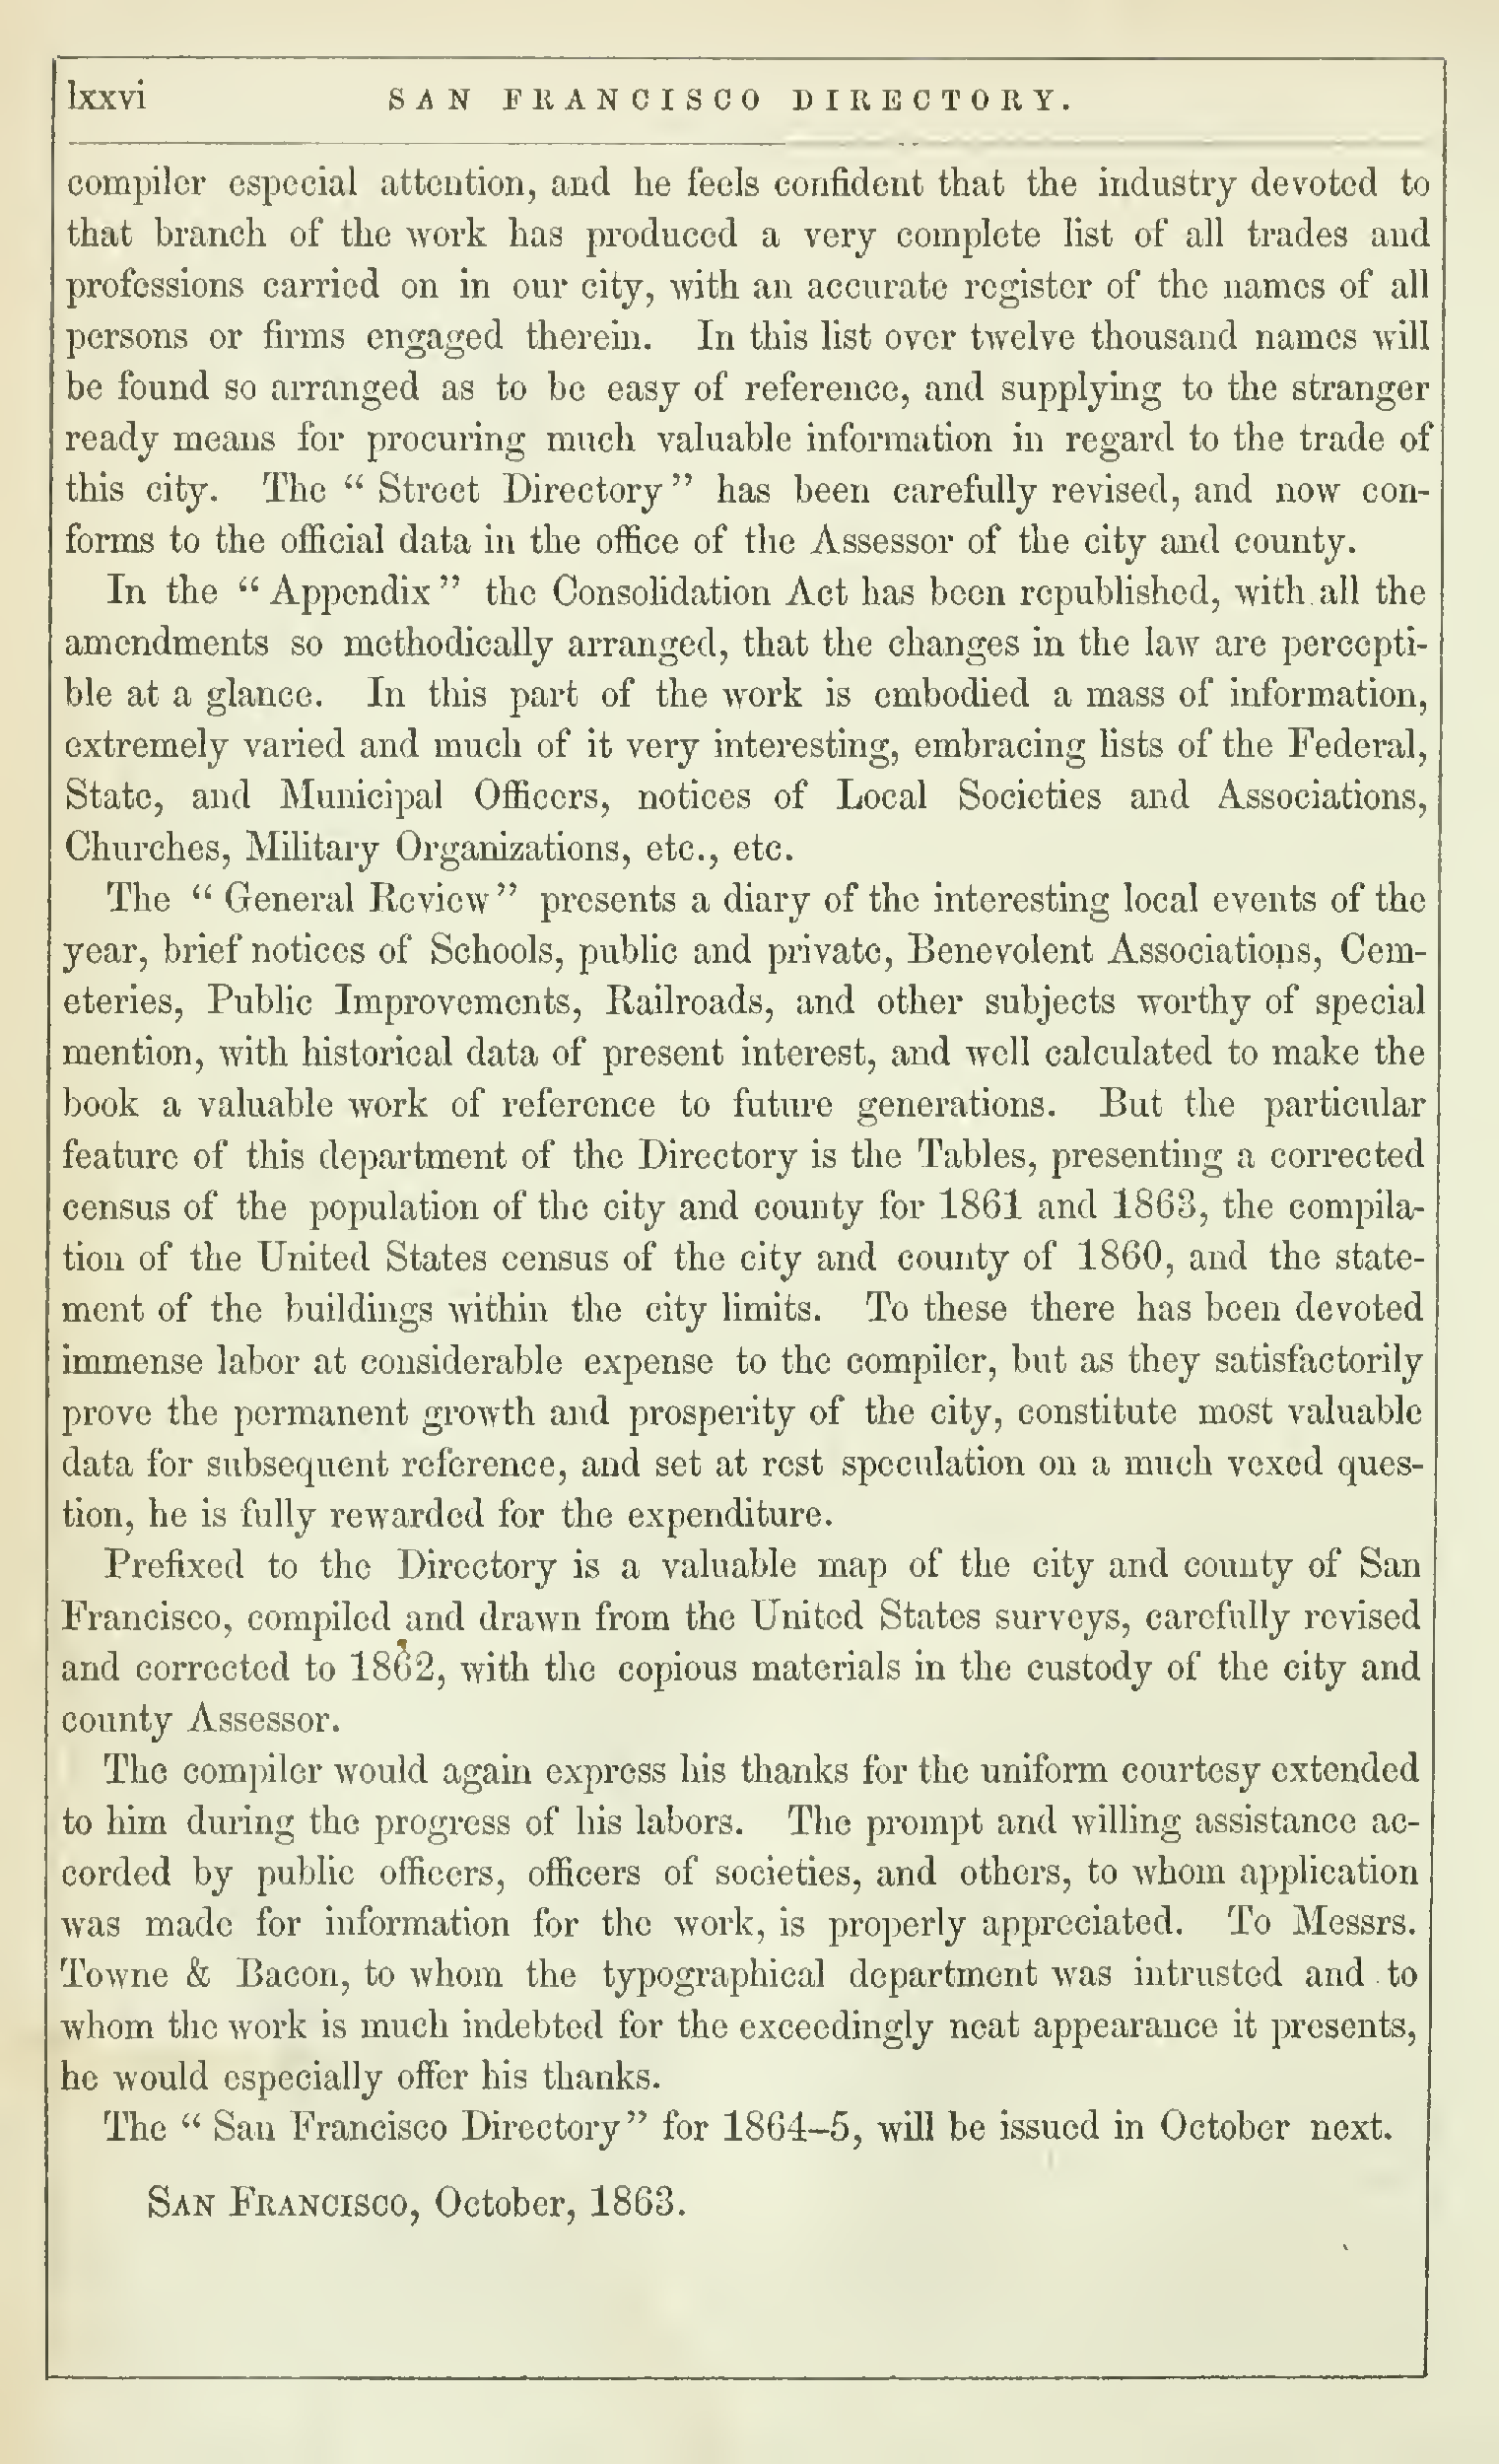

In [79]:
wandImage(all_pages.sequence[81])

In [63]:

page = wandImage(all_pages.sequence[pagenum])
with wandImage(page) as img:
    img.format = 'png'
    image_filename = 'temp.png'
    img.save(filename=image_filename)

    image = cv2.imread(image_filename)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    if args["preprocess"] == "thresh":
        gray = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1]
    elif args["preprocess"] == "blur":
        gray = cv2.medianBlur(gray, 3)

    cv2.imwrite('gray.png', gray)
    
plt.rcParams["figure.figsize"] = (50,30)


blockstats = pagecontents[pagenum]['blockstats']

# draw the bounding boxes on the image
h, w = gray.shape
img_blocks = gray.copy()
for index, row in blockstats.iterrows():
    top_left = (row['left_at'], row['top_at'])
    bottom_right = (row['right_at'], row['bottom_at'])
    img_blocks = cv2.rectangle(img_blocks, top_left, bottom_right, (0, 255, 0), 2)

# show the output image with block bounding boxes
plt.imshow(img_blocks,cmap='gray')
plt.show()


KeyError: 468

In [45]:
blockstats

,n_par,n_line,top_at,bottom_at,left_at,right_at
block,,,,,,
2,1,7,77,121,282,1453
4,26,223,166,1268,73,755
6,13,247,1297,2394,76,756
7,1,5,1266,1295,76,762
9,1,418,163,2117,779,1462
10,1,8,2112,2150,780,1458
11,7,45,2145,2400,784,1458
13,1,13,2430,2461,161,1374


In [56]:
pagecontents[361]

{'blockstats':        n_par  n_line  top_at  bottom_at  left_at  right_at
 block                                                     
 1          1       1      83        113       75       136
 2          1     471     169       2402       58       756
 3          1       1     962        970       58        60
 8          1       6      81        124      281      1160
 9         50     475     168       2374      780      1462
 10         1       1    2374       2396      842       903
 12         1      12    2436       2462      192      1355,
 'paragraphs': {1: ['2 7 6'],
  2: ['Noon Patrick, curman Janeen bet Greemwich and Lombard Noonan Abby, domestic Continental Hotel Noomm Dennis Bb. retortiman 8S. FP. Gas Co. dwl 220 Fremont, rear Noonan Edward, laborer, dw 411 Post. Noonan Jeremiuh, painter, dwl Ns Card Alley ar Stockion Noonan John, laborer Spring Valley Water W. Co Noonan Thomas, dvayman 739 Sacramento, dwl cor Third :md Folsom Noonan Willian, varnisber with J. Peirce, dw

In [60]:
isdirectory = [False]*len(all_pages.sequence)

In [49]:
isdirectory[360]=True

In [67]:
for i in range(124, 132):
    isdirectory[i] = True
for i in range(133,469):
    isdirectory[i] = True


In [59]:
len(all_pages.sequence)

682

In [62]:
isdirectory[300]

True

In [75]:
def showpage(all_pages, pagenum):

    page = wandImage(all_pages.sequence[pagenum])
    with wandImage(page) as img:
        img.format = 'png'
        image_filename = 'temp.png'
        img.save(filename=image_filename)

        image = cv2.imread(image_filename)

    plt.rcParams["figure.figsize"] = (50,30)
    
    blockstats = pagecontents[pagenum]['blockstats']

    # draw the bounding boxes on the image
    h, w = gray.shape
    img_blocks = image.copy()
    for index, row in blockstats.iterrows():
        top_left = (row['left_at'], row['top_at'])
        bottom_right = (row['right_at'], row['bottom_at'])
        img_blocks = cv2.rectangle(img_blocks, top_left, bottom_right, (0, 255, 0), 2)

    # show the output image with block bounding boxes
    plt.imshow(img_blocks,cmap='gray')
    plt.show()
    
    return True

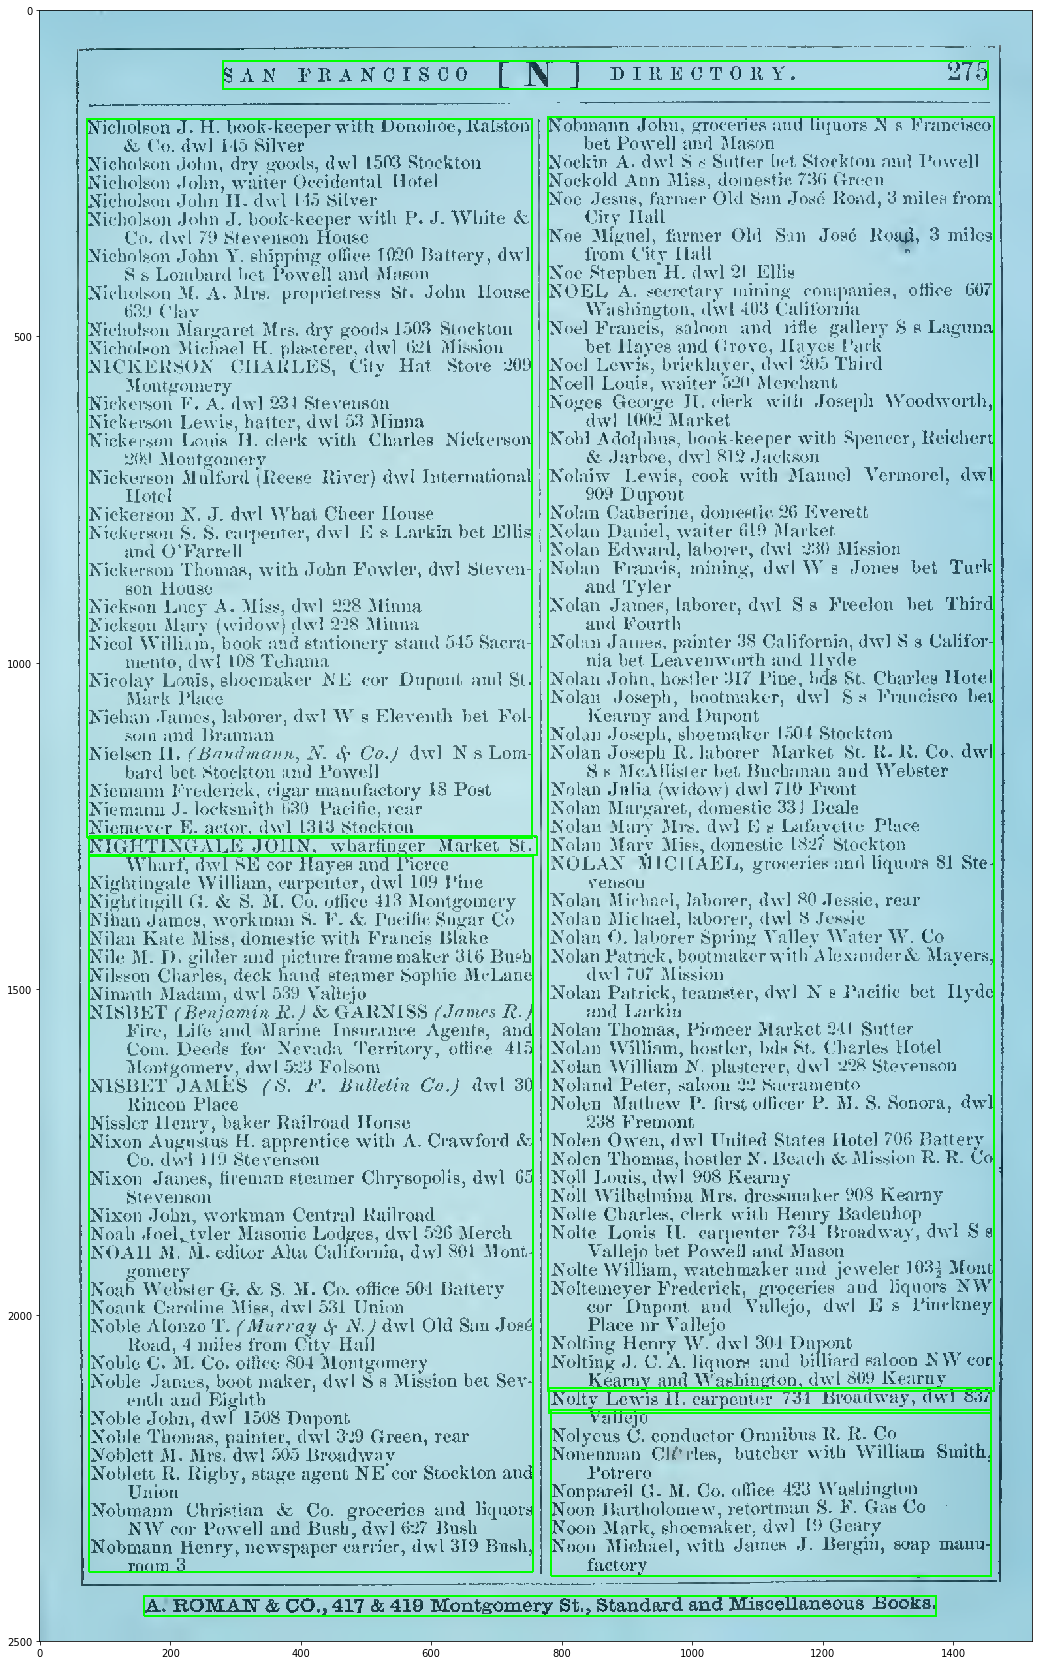

True

In [81]:
showpage(all_pages, 360)

In [66]:
pagenum

468